# Twitter Disaster Detection

### Goal

The goal of this project is to build a classifier that can identify tweets related to disasters. As a secondary objective, I will also investigate various techniques for exploring, preparing, and transforming the data.

### Data
The data for this project comes from an open Kaggle competition: https://www.kaggle.com/competitions/nlp-getting-started. It consists of tweets with the following information:

* text: the body of the tweet as free text
* keyword: a single word
* location: a single word
* target: an integer that indicates whether the tweet is related to a disaster (1) or not (0)

In [1]:
import pandas as pd

In [2]:
data = pd.read_csv("train.csv")
data.sample(5, random_state=42)

,id,keyword,location,text,target
2644,3796,destruction,NaN,So you have a new weapon that can cause un-ima...,1
2227,3185,deluge,NaN,The f$&amp;@ing things I do for #GISHWHES Just...,0
5448,7769,police,UK,DT @georgegalloway: RT @Galloway4Mayor: ÛÏThe...,1
132,191,aftershock,NaN,Aftershock back to school kick off was great. ...,0
6845,9810,trauma,"Montgomery County, MD",in response to trauma Children of Addicts deve...,0


In [3]:
data.shape

(7613, 5)

### Scope

For this project, I will train and compare six different models:

* ComplementNB (Naive Bayes Classifier)
* RidgeClassifier
* LogisticRegression
* DecisionTreeClassifier
* RandomForestClassifier 
* XGBClassifier

The metric that will be used to evaluate the performance of these models is F1, as required in the Kaggle competition.

### Structure
The research follows the following stages:
1. Exploratory data analysis, cleanup and feature engineering
1. Building pipelines and iteratively optimizing their steps
1. Testing the optimized pipelines on reserved test data
1. Observing results and drawing conclusions

# Imports and downloads

In [4]:
import numpy as np
import pandas as pd
import warnings

In [5]:
%load_ext autoreload
%autoreload 2

In [6]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.naive_bayes import ComplementNB
from sklearn.linear_model import RidgeClassifier, LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost.sklearn import XGBClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import PolynomialFeatures
import scipy.sparse as sp
from sklearn.decomposition import TruncatedSVD

from sklearn.feature_selection import SelectKBest, chi2

In [7]:
import nltk

In [8]:
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('omw-1.4')
nltk.download('averaged_perceptron_tagger')

[nltk_data] Downloading package stopwords to /home/iliav/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /home/iliav/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /home/iliav/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /home/iliav/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


True

In [9]:
from nltk.corpus import stopwords
from nltk.stem import SnowballStemmer
from nltk.tokenize import TweetTokenizer
from nltk.stem import WordNetLemmatizer
from nltk.tag import pos_tag
from nltk.corpus import wordnet

from sklearn.preprocessing import FunctionTransformer
import re

from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer

In [10]:
from sklearn.feature_selection import mutual_info_classif
from sklearn.metrics import f1_score
from sklearn.feature_extraction import DictVectorizer
import matplotlib.pyplot as plt 
from matplotlib.pyplot import figure
import seaborn as sns
import matplotlib.ticker as mticker

In [11]:
from sklearn import feature_extraction, linear_model, model_selection, preprocessing
from sklearn.feature_extraction.text import CountVectorizer

In [12]:
from IPython.display import clear_output

# EDA

In [13]:
data.head()

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


In [14]:
data.shape

(7613, 5)

## Initial cleanup

### Handling NaNs

* To avoid errors I replace NaNs with empty strings 

In [15]:
def na_counts(df):
    na_columns = df.columns[df.isna().any()]
    if len(na_columns)==0:
        return 0
    return df[na_columns].isna().apply(lambda x: x.value_counts())

In [16]:
na_counts(data)

,keyword,location
False,7552,5080
True,61,2533


In [17]:
data = data.fillna("")

## Exploring variables

### Duplicates and mislabeled data

It's possible that some tweets are duplicated. It's also possible that duplicates are labeled differently because of mistake on data collection stage
* I'm going to check only the `text` duplicates (i.e. even though `keyword` and `location` might differ).
* A record will be considered mislabeled if it has duplicates with different `target` value 

In [18]:
data.text.duplicated(keep=False).value_counts()

False    7434
True      179
Name: text, dtype: int64

In [19]:
data[data.text.duplicated(keep=False)].target.value_counts()

1    121
0     58
Name: target, dtype: int64

It's interesting that there are much more tweets labeled as positives (121 vs 58) among all the duplicates(179)

In [20]:
all_dups = data[data.duplicated(subset=['text'], keep=False)].text
all_dups.nunique()

69

In total 69 different texts have at least one duplicate

Checking which tweets have duplicates with opposite label:

In [21]:
mislabeled_dups = all_dups[all_dups.apply(lambda x: data[data.text==x].target.nunique()==2)]
data.iloc[mislabeled_dups.index].sort_values(by='text')[:10]

,id,keyword,location,text,target
4290,6094,hellfire,"Jubail IC, Saudi Arabia.",#Allah describes piling up #wealth thinking it...,0
4299,6105,hellfire,?????? ??? ?????? ????????,#Allah describes piling up #wealth thinking it...,0
4312,6123,hellfire,?????? ???? ??????,#Allah describes piling up #wealth thinking it...,1
4244,6031,hazardous,"New Delhi, Delhi",#foodscare #offers2go #NestleIndia slips into ...,0
4221,5996,hazardous,,#foodscare #offers2go #NestleIndia slips into ...,1
4239,6023,hazardous,"Mysore, Karnataka",#foodscare #offers2go #NestleIndia slips into ...,1
2832,4076,displaced,Pedophile hunting ground,.POTUS #StrategicPatience is a strategy for #G...,0
2831,4072,displaced,Pedophile hunting ground,.POTUS #StrategicPatience is a strategy for #G...,1
2830,4068,displaced,Pedophile hunting ground,.POTUS #StrategicPatience is a strategy for #G...,1
2833,4077,displaced,Pedophile hunting ground,.POTUS #StrategicPatience is a strategy for #G...,1


Creating a DataFrame with mislabeled tweets removed:

In [22]:
data_no_mislabeled = data.drop(mislabeled_dups.index)
data_no_duplicated = data.drop_duplicates(subset=['text'], keep=False)

In [23]:
work_data = data_no_mislabeled 

From this point forward, I will work with a cleaned dataset that has had mislabeled items removed. For now, I will keep properly labeled duplicates in the dataset, as they may reflect the real structure of Twitter data. However, I will test later whether removing all duplicates has any effect on the results.

### Helpers

Couple of helper function to get an overview of how particular words in a single-worded column are correlated with the target.

In [24]:
def vectorize_column(df, column_name):
    """
    Converts the values in a column of a dataframe into a numerical representation using a DictVectorizer.
    
    Parameters:
    df (pandas DataFrame): The dataframe containing the column to be vectorized.
    column_name (str): The name of the column to be vectorized.
    
    Returns:
    tuple: A tuple containing the DictVectorizer object used to vectorize the data, and the resulting vectors.
    
    Example:
    >>> vectorize_column(df, 'column1')
    (DictVectorizer(sparse=False), array([[1., 0., 0.], [0., 1., 0.], [0., 0., 1.]]))
    """    
    vectorizer = DictVectorizer(sparse=False)
    columns_dict = df[[column_name]].to_dict(orient='records')
    vectors = vectorizer.fit_transform(columns_dict)
    return (vectorizer, vectors)     

In [25]:
def sorted_correlation_coefficients(df, column_name, target_column_name):
    """
    Calculates and sorts the Pearson correlation coefficients between different words in a single-word column and a target column in a dataframe.
    
    Parameters:
    df (pandas.DataFrame): The dataframe containing the columns.
    column_name (str): The name of the single-word column to calculate correlations for.
    target_column_name (str): The name of the target column to calculate correlations with.
    
    Returns:
    list: A list of tuples containing the names of the columns and their corresponding correlation coefficients, sorted in descending order by the coefficient.
    
    Example:
    >>> calculate_correlation_coefficients(df, 'column1', 'target_column')
    [('column1_value1', 0.9), ('column1_value2', 0.8), ('column1_value3', 0.7)]
    """
    vectorizer, vectors = vectorize_column(df, column_name)
    transformed_columns = np.transpose(vectors)
    corrcoefs = [np.corrcoef(col, df[target_column_name])[0, 1] for col in transformed_columns]
    named_list = list(zip(vectorizer.get_feature_names_out(), corrcoefs))
    named_list.sort(key=lambda tup: tup[1], reverse=True)
    return named_list

In [26]:
# Analyzing mutual info score I want to compare it with such of a shuffled data
shuffled_target = work_data.target.sample(frac=1, random_state=10)

### Variable "keyword"

In [27]:
work_data.keyword.value_counts()

                         61
fatalities               45
deluge                   42
armageddon               42
damage                   41
                         ..
forest%20fire            19
epicentre                12
threat                   11
inundation               10
radiation%20emergency     9
Name: keyword, Length: 222, dtype: int64

In [28]:
mutual_info_classif(vectorize_column(work_data, 'keyword')[1], work_data['target']).mean(), mutual_info_classif(vectorize_column(work_data, 'keyword')[1], shuffled_target).mean()

(0.002503167404929306, 0.002517303886473455)

* The mutual info score of this variable and the target is higher than the "shuffled" score, so it might indicate that this feature has some predicting value

In [29]:
sorted_correlation_coefficients(work_data, "keyword", "target")[:10], sorted_correlation_coefficients(work_data, "keyword", "target")[-10:]

([('keyword=derailment', 0.08302992384814313),
  ('keyword=wreckage', 0.08302992384814298),
  ('keyword=debris', 0.08086218013088244),
  ('keyword=outbreak', 0.08040918816372149),
  ('keyword=typhoon', 0.07817379537898307),
  ('keyword=oil%20spill', 0.07817379537898284),
  ('keyword=suicide%20bombing', 0.07229181842864764),
  ('keyword=suicide%20bomber', 0.06980413608593596),
  ('keyword=rescuers', 0.06682449786303161),
  ('keyword=suicide%20bomb', 0.06682449786303152)],
 [('keyword=explode', -0.05032173057874939),
  ('keyword=wrecked', -0.05127748262122846),
  ('keyword=traumatised', -0.05128953808511176),
  ('keyword=screaming', -0.05224239029628636),
  ('keyword=electrocute', -0.05244341052765653),
  ('keyword=body%20bag', -0.05338676579344253),
  ('keyword=blazing', -0.05431426121493636),
  ('keyword=ruin', -0.057009050576103566),
  ('keyword=aftershock', -0.058308609736542324),
  ('keyword=body%20bags', -0.06042093668166045)])

* It's hard to interpret correlation coefficients at this point. Hopefully it will be more clear after experiments

### Variable "location"

In [30]:
work_data.location.value_counts()

                          2503
USA                        104
New York                    71
United States               50
London                      45
                          ... 
Paulton, England             1
SEA Server                   1
todaysbigstock.com           1
buenos aires argentina       1
Lincoln                      1
Name: location, Length: 3329, dtype: int64

In [31]:
mutual_info_classif(vectorize_column(work_data, 'location')[1], work_data['target']).mean(), mutual_info_classif(vectorize_column(work_data, 'location')[1], shuffled_target).mean()

(0.002213060558212054, 0.002282495380049601)

* The mutual info score of this variable and the target doesn't differ much from  the "shuffled" score. Probably it means that location doesn't add anything to prediction. We'll test this assumption during the pipelines training

In [32]:
sorted_correlation_coefficients(work_data, "location", "target")[:10], sorted_correlation_coefficients(work_data, "location", "target")[-10:]

([('location=USA', 0.05127865597035373),
  ('location=Mumbai', 0.04740569396538076),
  ('location=India', 0.046064880856544844),
  ('location=Nigeria', 0.04390256662704054),
  ('location=Washington, DC', 0.030385934048704856),
  ('location=Nairobi-KENYA', 0.026529183512312968),
  ('location=Bend, Oregon', 0.026529183512312888),
  ('location=Calgary', 0.02652918351231286),
  ('location=MAD as Hell', 0.026529183512312843),
  ('location=Sacramento', 0.02652918351231284)],
 [('location=Texas, USA', -0.022317363198970618),
  ('location=Leeds, England', -0.022317363198970635),
  ('location=Wisconsin', -0.02231736319897064),
  ('location=Coventry', -0.022317363198970652),
  ('location=ss', -0.024218473556252923),
  ('location=London, England', -0.024218473556252926),
  ('location=Morioh, Japan', -0.024449065050066745),
  ('location=Pennsylvania, USA', -0.026409757069899925),
  ('location=304', -0.02994981634009949),
  ('location=New York', -0.04013313127058214)])

### Variable "text"

In [33]:
count_vectorizer = CountVectorizer()
vectors = count_vectorizer.fit_transform(work_data['text'])
vectors.shape

(7558, 21612)

We have 21612 features. There's probably lots of garbage in there. I'll clean it up with different techniques, starting with setting min_df for CountVectorizer. I'll set it as an integer =10, meaning that words that occur less than 10 times in the training set will be excluded. The number 10 is picked quite arbitrarily and needs closer testing and tuning in the future

In [34]:
CountVectorizer(min_df=10).fit_transform(work_data['text']).shape

(7558, 1544)

This is already a good result. Later we'll use dimensionality reduction techniques to improve it

#### Hashtags

Tweets often contain hashtags that might highlight the main topic of the text. Let's look into them

In [35]:
hashtag_pattern = r'#(\w+)'

hashtags = work_data.text.str.lower().str.findall(hashtag_pattern)
ht_c_vect = CountVectorizer(min_df=10, analyzer=lambda x: x)
ht_vectors = ht_c_vect.fit_transform(hashtags)
ht_c_vect.get_feature_names_out(), len(ht_c_vect.get_feature_names_out())

(array(['bbc', 'best', 'earthquake', 'gbbo', 'hiring', 'hiroshima', 'hot',
        'india', 'isis', 'islam', 'japan', 'job', 'jobs', 'news',
        'nowplaying', 'prebreak', 'sismo', 'terrorism', 'world', 'yyc'],
       dtype=object),
 20)

##### Additional column
I'm creating new column to keep hashtags apart from the rest of vectorized tokens

In [36]:
work_data['hashtags'] = hashtags
work_data

,id,keyword,location,text,target,hashtags
0,1,,,Our Deeds are the Reason of this #earthquake M...,1,[earthquake]
1,4,,,Forest fire near La Ronge Sask. Canada,1,[]
2,5,,,All residents asked to 'shelter in place' are ...,1,[]
3,6,,,"13,000 people receive #wildfires evacuation or...",1,[wildfires]
4,7,,,Just got sent this photo from Ruby #Alaska as ...,1,"[alaska, wildfires]"
...,...,...,...,...,...,...
7608,10869,,,Two giant cranes holding a bridge collapse int...,1,[]
7609,10870,,,@aria_ahrary @TheTawniest The out of control w...,1,[]
7610,10871,,,M1.94 [01:04 UTC]?5km S of Volcano Hawaii. htt...,1,[]
7611,10872,,,Police investigating after an e-bike collided ...,1,[]


#### URLs
Same as hashtags there might be urls in the text. Tokenizing them might create some noise on one hand and loose some information on the other. For that reason I'll also create another column to keep them apart

In [37]:
url_pattern =  r'(https?:\/\/(?:www\.)?[-a-zA-Z0-9@:%._+~#=]{1,256}\.[a-zA-Z0-9()]{1,6}[-a-zA-Z0-9()@:%_+.~#?&/=]*)'

In [38]:
work_data.text[work_data.text.str.findall(url_pattern).apply(len) > 0].shape

(3965,)

Number of items containing url is quite big

Let's observe correlation of different words with target

In [39]:
columns = np.transpose(vectors.todense().A)
corrcoefs = [np.corrcoef(col, work_data.target)[0, 1] for col in columns]
named_list = list(zip(count_vectorizer.get_feature_names_out(), corrcoefs))
named_list.sort(key=lambda tup: tup[1], reverse = True)

In [40]:
named_list[0:10], named_list[-10:]

([('http', 0.21452627610618558),
  ('co', 0.197184075655397),
  ('in', 0.1671580742879547),
  ('california', 0.1310149967949288),
  ('suicide', 0.12455801698077225),
  ('hiroshima', 0.1210916441867206),
  ('killed', 0.11979142932138698),
  ('mh370', 0.11002041366833958),
  ('wildfire', 0.10672655178990342),
  ('northern', 0.10654069392403501)],
 [('if', -0.06876362740044957),
  ('can', -0.07148314636945576),
  ('it', -0.07295391366915743),
  ('full', -0.07322194151418458),
  ('so', -0.07565381719162129),
  ('your', -0.0779455118166616),
  ('body', -0.08382709834151313),
  ('me', -0.08893371278948647),
  ('my', -0.12906704047732429),
  ('you', -0.15455528784196004)])

Here I'm vectorizing urls, taking each of them as a whole token:

In [41]:
urls = work_data.text.str.lower().str.findall(url_pattern)
url_c_vect = CountVectorizer(min_df=3, analyzer=lambda x: x)
url_vectors = url_c_vect.fit_transform(urls)
url_c_vect.get_feature_names_out(), len(url_c_vect.get_feature_names_out())

(array(['http://t.co/0wratka2jl', 'http://t.co/9nwajli9cr',
        'http://t.co/bbdpnj8xsx', 'http://t.co/cedcugeuws',
        'http://t.co/cybksxhf7d', 'http://t.co/encmhz6y34',
        'http://t.co/ksawlyux02', 'http://t.co/lvlh3w3awo',
        'http://t.co/nnmqlz91o9', 'http://t.co/o91f3cyy0r',
        'http://t.co/q2eblokeve', 'http://t.co/qew4c5m1xd',
        'http://t.co/thoyhrhkfj', 'http://t.co/v3azwoamzk',
        'http://t.co/viwxy1xdyk', 'http://t.co/vvplfqv58p',
        'http://t.co/wvj39a3bgm', 'http://t.co/zujwuiomb3',
        'https://t.co/dehmym5lpk', 'https://t.co/e8dl1lncvu',
        'https://t.co/moll5vd8yd'], dtype=object),
 21)

Even after setting `min_df` as low as 3, there are only 21 URLs that make into the dictionary. So probably they won't be very predictive, but let's add them as a separate column anyway

##### Additional column
Here I'm creating another column to keep urls apart from the rest of vectorized tokens

In [42]:
work_data['urls'] = urls

In [43]:
work_data

,id,keyword,location,text,target,hashtags,urls
0,1,,,Our Deeds are the Reason of this #earthquake M...,1,[earthquake],[]
1,4,,,Forest fire near La Ronge Sask. Canada,1,[],[]
2,5,,,All residents asked to 'shelter in place' are ...,1,[],[]
3,6,,,"13,000 people receive #wildfires evacuation or...",1,[wildfires],[]
4,7,,,Just got sent this photo from Ruby #Alaska as ...,1,"[alaska, wildfires]",[]
...,...,...,...,...,...,...,...
7608,10869,,,Two giant cranes holding a bridge collapse int...,1,[],[http://t.co/stfmbbzfb5]
7609,10870,,,@aria_ahrary @TheTawniest The out of control w...,1,[],[]
7610,10871,,,M1.94 [01:04 UTC]?5km S of Volcano Hawaii. htt...,1,[],[http://t.co/zdtoyd8ebj]
7611,10872,,,Police investigating after an e-bike collided ...,1,[],[]


#### Emoji
Another type of different tokens might be Emojis

In [44]:
import emoji

In [45]:
print(work_data.text.apply(emoji.distinct_emoji_list)[work_data.text.apply(emoji.emoji_count) > 0])

2171    [©]
2172    [©]
2173    [©]
2179    [©]
3479    [©]
4390    [©]
7127    [©]
7514    [©]
7527    [©]
7532    [©]
Name: text, dtype: object


### Target value counts
Exploring how balanced is the set

<AxesSubplot: >

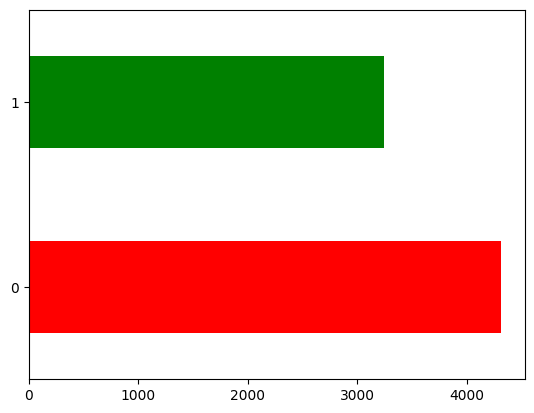

In [46]:
work_data.target.value_counts().plot.barh(color=['red', 'green'])

In [47]:
print(work_data.target.value_counts())

0    4313
1    3245
Name: target, dtype: int64


The data is somewhat imbalanced, so I need to keep an eye on using the proper settings for our models

# Training Models

## Plan

I'm going to try various data preparation and transformation steps and try them on several different classification models.
The whole pipeline will be as follows:

1. __Data Preparation__
    1. CountVectorizer applied to the `text` column as central part of preparation
    1. Additional steps:
        1. Cleanup URLs from text
        1. `keyword` column vectorization
        1. `location` column vectorization
        1. The newly created `hashtags` and `urls` columns vectorization
        1. Using stopwords
        1. Stemming
        1. Lemmatization
        1. ngrams
    1. By end of this stage I'll get a sparce matrix of vectors, that could be fed into different models. Testing different combinations I'll find the best steps for each model
1. __Data transformation and dimensionality reduction__
    1. The following techniques will be performed on the data from the previous stage:
        1. Feature Polynomialization
            * the reason to try this technique is a hypothesis that some words might have higher predictive power in combination for other words. The idea is similar to ngrams, but doesn't require words to be next to each other in the text
        1. SelectKBest
            * this technique 
        1. TruncatedSVD
    1. GridSearchCV will be used to find the most winning sequence
1. __Final Model Parameter Tuning__
    1. For each model with its optimal data pipeline, I will perform hyperparameter tuning.
1. __Testing__
    1. After each of the above stages, I will record the score on the test data to detect any overfitting.

#### Example of a full pipeline

In [48]:
from util.pipeline_util import make_transformation_pipeline

make_transformation_pipeline(DecisionTreeClassifier(),  {'kw': True, 'hashtags': True, 'loc': True})

Pipeline(steps=[('url_cleaner', None),
                ('vectorizer',
                 ColumnTransformer(transformers=[('text_c_vect',
                                                  CountVectorizer(min_df=10),
                                                  'text'),
                                                 ('kw_dict_vect',
                                                  Pipeline(steps=[('kw_to_dict',
                                                                   FunctionTransformer(func=<function series_to_dict at 0x7f6134ac69e0>)),
                                                                  ('d_vect',
                                                                   DictVectorizer())]),
                                                  'keyword'),
                                                 ('loc_dict_vect',
                                                  Pipeline(steps=[('loc_to_dict',
                                                                   FunctionTransf...
                                                  'location'),
                                                 ('hashtags_c_vect',
                                                  CountVectorizer(analyzer=<function make_vectorizer.<locals>.<lambda> at 0x7f6134ac68c0>,
                                                                  min_df=5),
                                                  'hashtags')])),
                ('poly2_k_best',
                 Pipeline(steps=[('poly2', PolynomialFeatures()),
                                 ('k_best',
                                  SelectKBest(score_func=<function chi2 at 0x7f6197d65240>))])),
                ('svd', TruncatedSVD(random_state=42)),
                ('classifier', DecisionTreeClassifier())])

### Data Preparation Helpers and Transformers
Here I'm preparing several transformers to apply to the `text` data, such as stemming, lemmatization and stopwords. The former two are intended to make different forms of a word to be mapped to the same token. The latter is intended to reduce the noize from words with low semantic value

In [49]:
stopwords_english = stopwords.words('english')
stemmer = SnowballStemmer(language='english')
lemmatizer = WordNetLemmatizer()

def pos_for_tag(tag):
        if tag.startswith('V'):
            return 'v'
        elif tag.startswith('J'):
            return('a')
        elif tag.startswith('R'):
            return('r')
        else:
            return('n')
        
def lemma_preprocessor_full(text):
    words=[lemmatizer.lemmatize(w, pos_for_tag(tag)) for w, tag in pos_tag(re.split("\\s+",text))]
    return ' '.join(words)

def stem_preprocessor(text):
    words=[stemmer.stem(w) for w in re.split("\\s+",text)]
    return ' '.join(words)

Below is a transformer to remove all URLs from the `text` column

In [50]:
def url_clean(df):
    df = df.copy()
    df.text = df.text.replace(url_pattern, '', regex=True)
    return df

url_cleaner = FunctionTransformer(url_clean)

### Train-Test Data Split
* X_full_train and y_full_train will be used for grid search and parameters tuning
* X_test and y_test will be only touched to test the tuned pipelines on different steps to control overfitting

In [51]:
df_full_train, df_test = train_test_split(work_data, test_size=0.2, random_state=42)
df_full_train.shape, df_test.shape

((6046, 7), (1512, 7))

In [52]:
X_full_train = df_full_train.drop('target', axis=1)
y_full_train = df_full_train.target

X_test = df_test.drop('target', axis=1)
y_test = df_test.target

cv = model_selection.StratifiedKFold(4, shuffle=True, random_state=55)

#### Prototyping sets
These data sets and cvs are used to quickly prototype a segment of data research. 
In the end they shouldn't appear anywhere in this notebook 

In [53]:
small_train, small_test = train_test_split(work_data, test_size=0.9, random_state=42)
small_train.shape, small_test.shape

X_small = small_train.drop('target', axis=1)
y_small = small_train.target

cv_small_fast = [next(cv.split(X_small, y_small))]
cv_fast = [next(cv.split(X_full_train, y_full_train))]

## Data Preparation

### Steps combinations

The following preparation steps combinations were created after several iterations of the Data Preparation stage.
It would have been be too slow to test all possible combinations, so some trial and error approach was needed

In [54]:
all_preparation_params = {
    'Url Cleaner': {'url_cleaner': url_cleaner},
    'Stemming': {'preprocessor': stem_preprocessor},
    'Lemmatization': {'preprocessor': lemma_preprocessor_full},
    'Keyword': {'kw': True},
    'Location': {'loc': True},
    'Hashtags': {'hashtags': True},   
    'URLs': {'urls': True},
    'Stopwords': {'stopwords': stopwords_english},    
    '1-2 words ngrams': {'ngram_range': (1, 2)},
    '1-3 words ngrams': {'ngram_range': (1, 3)},

    'Stopwords + Stemming': {'stopwords': stopwords_english, 'preprocessor': stem_preprocessor},  
    'Stopwords + Lemmatization': {'stopwords': stopwords_english, 'preprocessor': lemma_preprocessor_full},
    'Keyword + URL Cleaner': {'url_cleaner': url_cleaner, 'kw': True},
    'Keyword + Stemming': {'url_cleaner': url_cleaner, 'preprocessor': stem_preprocessor},
    'Stopwords + URL Cleaner': {'stopwords': stopwords_english, 'url_cleaner': url_cleaner},
    'Stopwords + Keyword': {'stopwords': stopwords_english, 'kw': True},
    'Stopwords + Location': {'stopwords': stopwords_english, 'loc': True},
    'Stopwords + Hashtags': {'stopwords': stopwords_english, 'hashtags': True},
    'Stopwords + 1-2 ngrams': {'stopwords': stopwords_english, 'ngram_range': (1, 2)},
    'Stopwords + Stemming + Keyword': {'stopwords': stopwords_english, 'kw': True, 'preprocessor': stem_preprocessor},
    'Stopwords + Stemming + Location': {'stopwords': stopwords_english, 'loc': True, 'preprocessor': stem_preprocessor},
    'Stopwords + Stemming + Hashtags': {'stopwords': stopwords_english, 'hashtags': True, 'preprocessor': stem_preprocessor},
    'Stopwords + Stemming + URL Cleaner': {'stopwords': stopwords_english, 'preprocessor': stem_preprocessor, 'url_cleaner': url_cleaner},
    'Stopwords + Stemming + 1-2 ngrams': {'stopwords': stopwords_english, 'preprocessor': stem_preprocessor, 'ngram_range': (1, 2)}, 
    'Keyword + Location': {'kw': True, 'loc': True},
    'Keyword + Hashtags': {'kw': True, 'hashtags': True},
    'Keyword + location + Hashtags': {'kw': True, 'hashtags': True, 'loc': True},
    'Keyword + Location + Stemming': {'kw': True, 
                                      'loc': True,
                                      'preprocessor': stem_preprocessor},
    'Keyword + Location + Hashtags + Stemming': {'kw': True,
                                                 'hashtags': True, 
                                                 'loc': True,
                                                 'preprocessor': stem_preprocessor}
}

### List of models

Across the notebook below we'll access models by these keys 

In [55]:
class Models:
    nb_key = 'Naive Bayes'
    rc_key = 'Ridge Classifier'
    lr_key = 'Logistic Regression'
    tree_key = 'Tree'
    forest_key = 'Forest'
    xgb_key = 'XGBoost'

While majority of the models can handle it automatically or with a setting, XGBoost needs this to be set explicitly:

In [56]:
scale_pos_weight = y_full_train.value_counts()[0] / y_full_train.value_counts()[1]

To avoid dragging model parameters between different grid searches I need to create every time a new one. Most of the models can self adjust to imbalanced set when passed the `class_weight="balanced"` parameter

In [57]:
def make_model(key):
    match key:     
        case Models.nb_key:
            return ComplementNB() #This Naive Bayes classifier is meant to work well with imbalanced data sets
        case Models.rc_key:
            return RidgeClassifier(class_weight="balanced")
        case Models.lr_key:
            return LogisticRegression(class_weight="balanced", max_iter=500)
        case Models.tree_key:
            return DecisionTreeClassifier(class_weight="balanced", random_state=42)
        case Models.forest_key:
            return RandomForestClassifier(class_weight="balanced", n_jobs=-1, random_state=42)
        case Models.xgb_key:
            return XGBClassifier(scale_pos_weight=scale_pos_weight, n_jobs=0)

In [58]:
%%time
all_models_keys = [ 
        Models.nb_key, 
        Models.rc_key, 
        Models.lr_key, 
        Models.tree_key, 
        Models.forest_key, 
        Models.xgb_key
    ]

CPU times: user 5 µs, sys: 0 ns, total: 5 µs
Wall time: 6.44 µs


In [59]:
from util.plot_util import plot_score_diffs

### Steps evaluation

In [60]:
from util.pipeline_util import make_preparation_pipeline

#### Helpers

In [61]:
from sklearn.model_selection import cross_val_score

def evaluate_pipelines(pipelines, feature_key=None, with_test=True):
    """
    Evaluate a set of pipelines using cross-validation and, optionally, a test set.
    
    Parameters:
    - pipelines (dict): A dictionary where the keys are strings representing the name of the model and the values are
                       sklearn Pipeline objects.
    - feature_key (str): A string representing the key for the transformation steps used in the pipelines. Default is None.
    - with_test (bool): A boolean indicating whether to also evaluate the pipelines using a test set. Default is True.
    
    Returns:
    - pandas DataFrame: A dataframe with the F1 scores for the pipelines, with the rows representing the cross-validation
                       scores and, optionally, the test set scores. The dataframe has a 'Features' column indicating
                       the transformation steps used and a column for each model, with the model names as column labels.
    """
    record_dict = {'Features': f'{feature_key} (x_val)'}
    test_record_dict = {'Features': f'{feature_key} (test)'}
 
    for model_key, pipeline in pipelines.items():
        steps = pipeline.steps.copy()
        if not any(step for step in steps if step[0] == 'classifier'):
            steps.append(('classifier', make_model(model_key)))
        clf_pipeline = Pipeline(steps)
        
        score = cross_val_score(clf_pipeline, X_full_train, y_full_train, scoring='f1', cv=cv).mean()

        clf_pipeline.fit(X_full_train, y_full_train)
        record_dict[model_key] = score

        if with_test:
            test_score = f1_score(y_test, clf_pipeline.predict(X_test))
            test_record_dict[model_key] = test_score    
    
    scores_df = pd.DataFrame([record_dict])
    if with_test:
        scores_df = pd.DataFrame([record_dict, test_record_dict])
    scores_df.set_index('Features', inplace=True)
    return scores_df

In [62]:
def xval_pipe_with_clf(pipeline, clf):
    """
    Evaluate a pipeline with a specified classifier using cross-validation.
    
    Parameters:
    - pipeline (sklearn Pipeline): The pipeline to evaluate.
    - clf (sklearn estimator): The classifier to use in the pipeline.
    
    Returns:
    - float: The mean F1 score from cross-validation.
    """    
    steps = pipeline.steps.copy()
    steps.append(('classifier', clf))
    clf_pipeline = Pipeline(steps)

    return cross_val_score(clf_pipeline, X_full_train, y_full_train, scoring='f1', cv=cv).mean()

def xval_pipes_and_models(pipelines, models_keys):
    """
    Evaluate a set of pipelines with a set of models using cross-validation.
    
    Parameters:
    - pipelines (dict): A dictionary where the keys are strings representing the name of the transformation steps and the
                       values are sklearn Pipeline objects.
    - models_keys (list): A list of strings representing the keys for the models to use.
    
    Returns:
    - pandas DataFrame: A dataframe with the F1 scores for the pipelines with the models specified, with the rows
                       representing the transformation steps and the columns representing the models. The dataframe has a
                       'Features' column indicating the transformation steps used and a column for each model, with the
                       model names as column labels.
    """    
    df = pd.DataFrame()

    for key, pipeline in pipelines.items():
        record_dict = {model_key: xval_pipe_with_clf(pipeline, make_model(model_key)) for model_key in models_keys}
        record_dict['Features'] = key
        df = pd.concat([df, pd.DataFrame([record_dict])])

    df.set_index('Features', inplace=True)
    
    return df

#### Default scores
These are scores for models with basic settings only trained on the vectorized `text` column without any preparation steps

In [63]:
default_pipelines = {
    key: make_preparation_pipeline() for key in all_models_keys
}

In [64]:
default_scores_df = evaluate_pipelines(default_pipelines, feature_key='Default')

In [65]:
default_scores_df

,Naive Bayes,Ridge Classifier,Logistic Regression,Tree,Forest,XGBoost
Features,,,,,,
Default (x_val),0.733873,0.721860,0.734567,0.662804,0.700984,0.736132
Default (test),0.760383,0.758837,0.762422,0.669298,0.727909,0.742475


Building and cross-validating pipelines on all the preparation steps combinations

In [66]:
all_preparation_pipelines = {
    key: make_preparation_pipeline(**params) for key, params in all_preparation_params.items()
}

In [67]:
%%time
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    all_preparation_scores = xval_pipes_and_models(all_preparation_pipelines, all_models_keys)

CPU times: user 9min 36s, sys: 7.44 s, total: 9min 43s
Wall time: 7min 18s


#### Preparation steps effect
Here are cross-validation score differences for various preparation steps combinations against the default pipeline

In [68]:
pd.concat([all_preparation_scores, default_scores_df])

,Naive Bayes,Ridge Classifier,Logistic Regression,Tree,Forest,XGBoost
Features,,,,,,
Url Cleaner,0.738323,0.720316,0.733242,0.657123,0.716152,0.722848
Stemming,0.728849,0.721593,0.738845,0.664785,0.704046,0.733400
Lemmatization,0.713270,0.706847,0.719422,0.639835,0.676520,0.717130
Keyword,0.748595,0.723676,0.738634,0.666847,0.715289,0.733774
Location,0.731503,0.718256,0.737130,0.672442,0.700240,0.731113
Hashtags,0.734102,0.722807,0.734220,0.659374,0.704767,0.736099
URLs,0.733386,0.723773,0.734519,0.655434,0.697957,0.736132
Stopwords,0.727567,0.724085,0.733207,0.687172,0.715000,0.733127
1-2 words ngrams,0.721602,0.710679,0.733575,0.660325,0.693024,0.735004


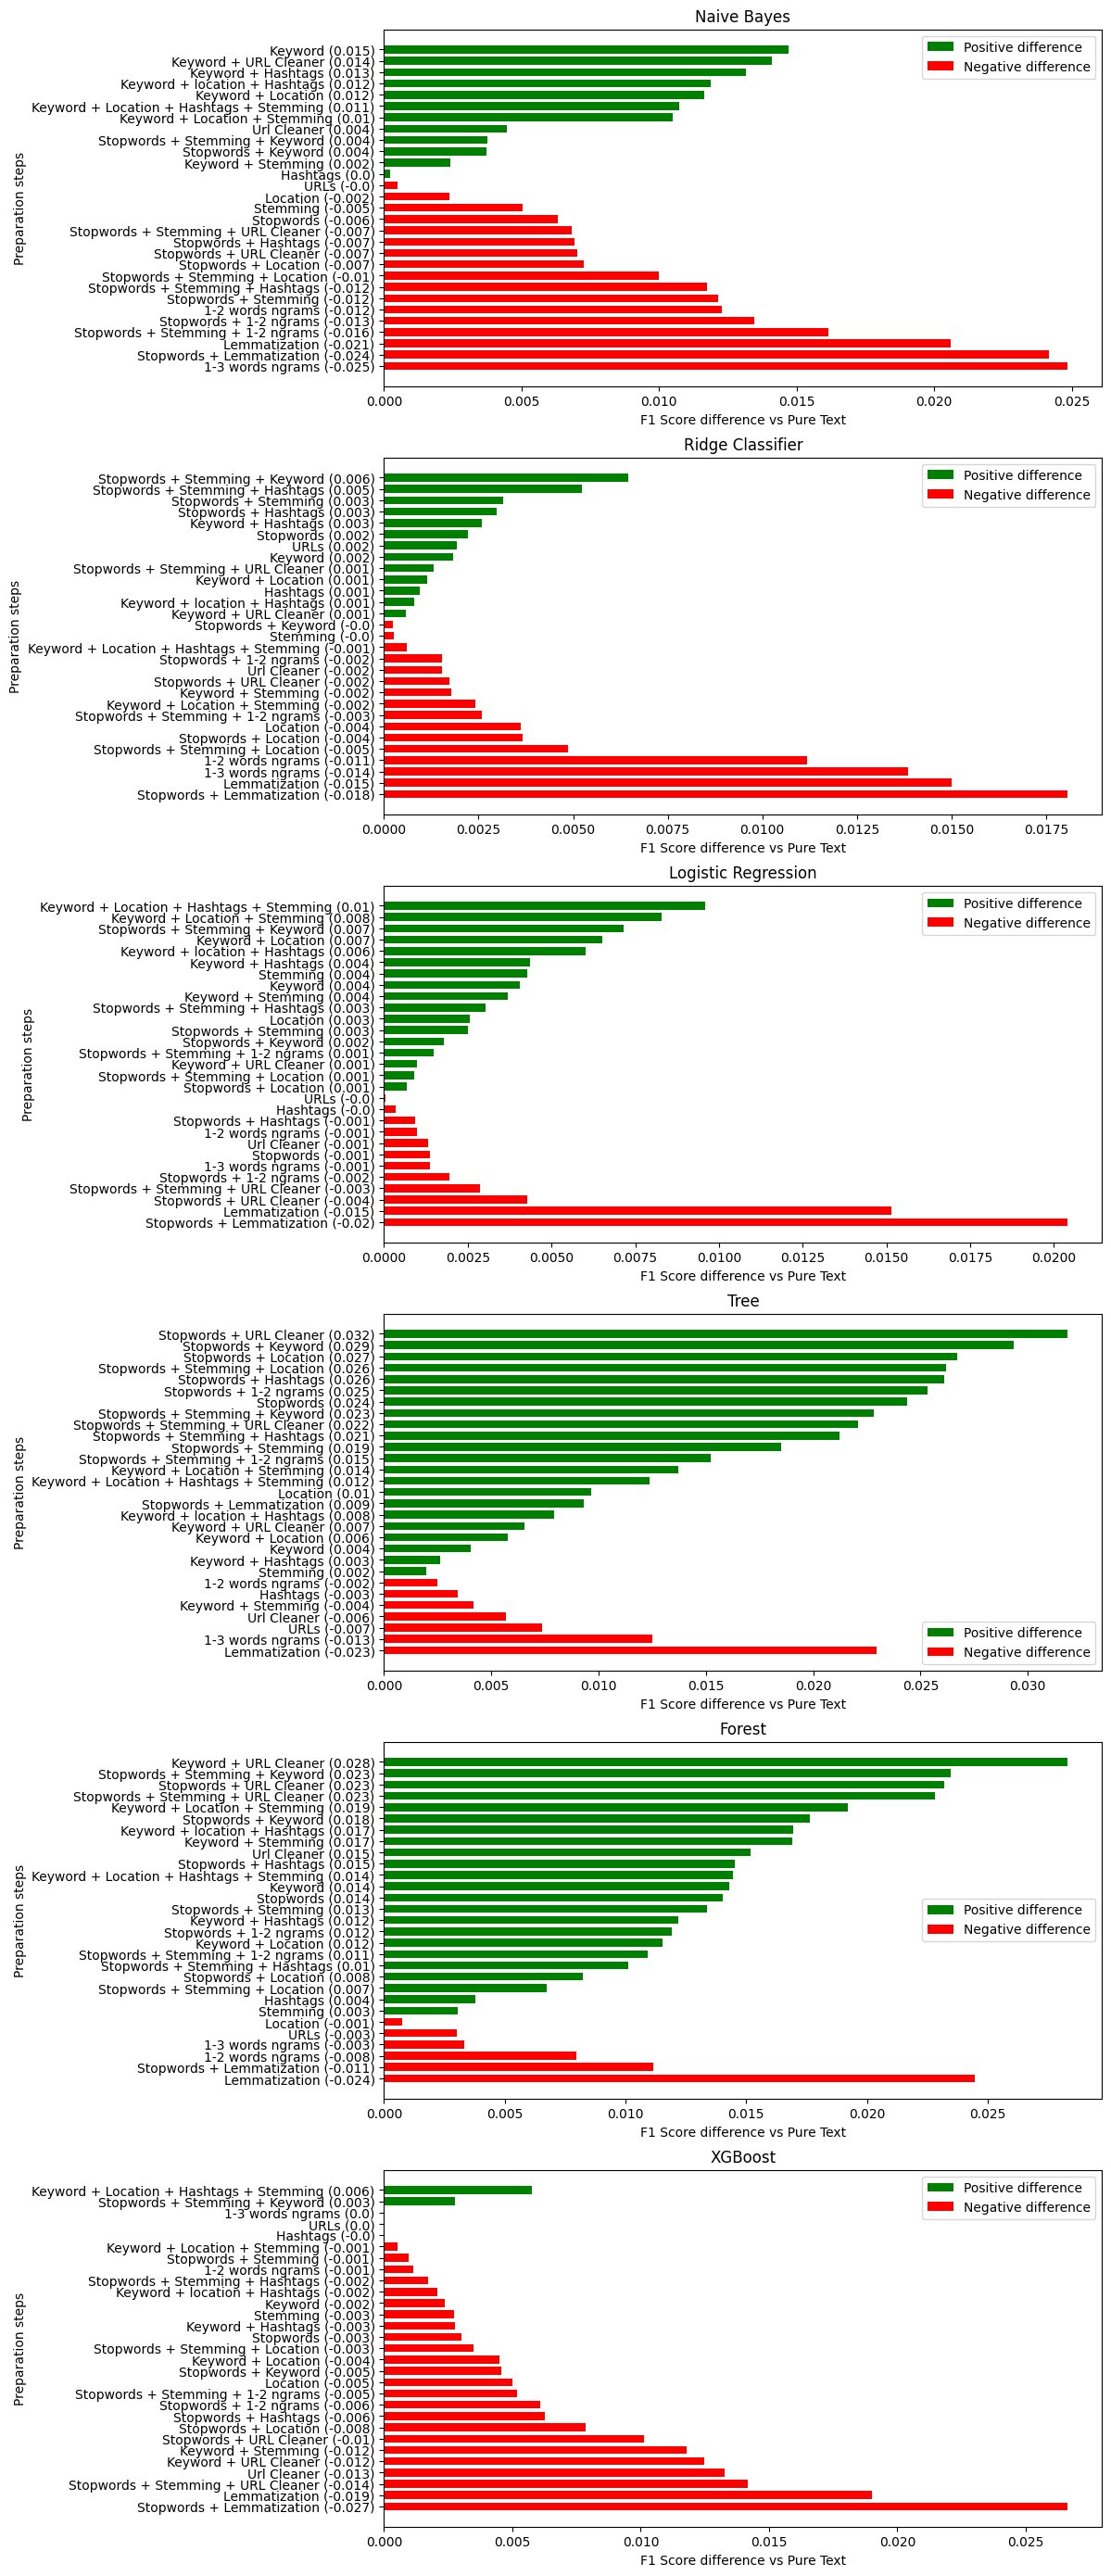

In [69]:
preparation_diffs = all_preparation_scores - default_scores_df.loc['Default (x_val)']
plot_score_diffs(preparation_diffs)

### Best preparation parameters
Some of the differences are neglectible and are obviously just fluctuations. For now I'll just blindly take the best performing combinations, but later this needs more attention

In [70]:
best_preparation_params = preparation_diffs.idxmax()
best_preparation_params

Naive Bayes                                             Keyword
Ridge Classifier                 Stopwords + Stemming + Keyword
Logistic Regression    Keyword + Location + Hashtags + Stemming
Tree                                    Stopwords + URL Cleaner
Forest                                    Keyword + URL Cleaner
XGBoost                Keyword + Location + Hashtags + Stemming
dtype: object

In [71]:
best_preparation_pipelines = {
    key: all_preparation_pipelines[params_key] for key, params_key in best_preparation_params.items()
}

### Preparation scores

In [72]:
%%time
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    preparation_scores_df = evaluate_pipelines(best_preparation_pipelines, feature_key='Data preparation')

CPU times: user 29.5 s, sys: 418 ms, total: 29.9 s
Wall time: 15.8 s


In [73]:
pd.concat((default_scores_df, preparation_scores_df))

,Naive Bayes,Ridge Classifier,Logistic Regression,Tree,Forest,XGBoost
Features,,,,,,
Default (x_val),0.733873,0.721860,0.734567,0.662804,0.700984,0.736132
Default (test),0.760383,0.758837,0.762422,0.669298,0.727909,0.742475
Data preparation (x_val),0.748595,0.728327,0.744144,0.694677,0.729309,0.741877
Data preparation (test),0.773688,0.762805,0.767677,0.701700,0.740995,0.759367


### Conslusion
* There is some improvement on cross-val score for all models, and it is supported by the test score
* Hence for each model the pipeline will be based on the best preparation parameters

## Data Transformation. Polynomialization and Dimensionality Reduction

### Polynomial Features and SelectKBest with chi2 algorithm
At this step I take the data from previous step and apply two different transformation to it:
1. Directly SelectKBest
1. First Polynomial Features and then SelectKBest on top of it
    1. The hypothesis behind using PolynomialFeatures is that some words might affect the meaning of the text in combination with the others. The idea is somewhat similar to using ngrams, but the words do not need to be placed next to each other, just to occur in the same text together
    1. The result of Polynomial Features is too high-dimensional, so it can't be used on it's own, hence we need to apply SelectKBest anyways
* Using knowledge of the number of features generated on the previous we'll build ranges for k and find the optimal values for cases with and without Polynomial Features

#### Helpers

The following is a function generating a pipeline based on the previously selected best preparation parameters

In [74]:
def pipe_with_transformations(key):
    """
    Create a pipeline with a model key based on the previously selected best preparation parameters
    
    Parameters:
    - key (str): The key for the model
    
    Returns:
    - sklearn Pipeline: A pipeline with the model and transformation steps specified by the key.
    """    
    return make_transformation_pipeline(
        make_model(key),
        all_preparation_params[best_preparation_params[key]]
    )

In [75]:
def min_n_features(key, X=X_full_train, y=y_full_train):
    """
    Calculate the minimum number of features across CV splits after applying the transformation steps specified by the key.
    
    Parameters:
    - key (str): The key for the transformation steps to use.
    - X (numpy array or pandas DataFrame): The input data. Default is X_full_train.
    - y (numpy array or pandas Series): The target data. Default is y_full_train.
    
    Returns:
    - int: The minimum number of features across CV splits after applying the transformation steps.
    """        
    pipeline = make_preparation_pipeline(**all_preparation_params[best_preparation_params[key]])
    pipeline.fit(X, y)
    min_n = None
    for split in cv.split(X, y):
        n = pipeline.fit_transform(X.iloc[split[0]], y.iloc[split[0]]).shape[1]
        min_n = n if min_n is None else min(n, min_n)
            
    return min_n

Checking what's the minimum n featers per split we have for each pipeline. It's helpful to build the ranges for the k value

In [76]:
with warnings.catch_warnings():
    warnings.simplefilter('ignore')
    mins = {key: min_n_features(key) for key in all_models_keys}
    print(mins)

{'Naive Bayes': 1256, 'Ridge Classifier': 1128, 'Logistic Regression': 3427, 'Tree': 915, 'Forest': 1253, 'XGBoost': 3427}


In [77]:
# these ranges where obtained after couple iterations
k_ranges_dict = {
    Models.nb_key: np.concatenate(
                            (np.linspace(400, 1100, 5, dtype=int),
                            np.linspace(5000, 15000, 3, dtype=int))),
    Models.rc_key:  np.concatenate(
                            (np.linspace(400, 1100, 5, dtype=int),
                             np.linspace(2500, 7000, 3, dtype=int))),
    Models.lr_key:  np.concatenate(
                            (np.linspace(600, 1100, 6, dtype=int),
                             np.linspace(2000, 7000, 3, dtype=int))),
    Models.tree_key: np.concatenate(
                            (np.linspace(200, 1000, 9, dtype=int),
                            np.linspace(2000, 8000, 5, dtype=int))),
    Models.forest_key: np.concatenate(
                            (np.linspace(600, 1100, 6, dtype=int),
                             np.linspace(2000, 7000, 6, dtype=int))),
    Models.xgb_key: np.concatenate(
                            (np.linspace(1000, 3000, 7, dtype=int),
                            np.linspace(4000, 7000, 3, dtype=int)))
}

#### Calculation

In [78]:
from util.preprocess_util import k_range_scores, svd_n_range_scores
from util.plot_util import plot_k_range_results, plot_svd__range_results

In [79]:
%%time
k_ranged_pipelines = {
    k: (pipe_with_transformations(k),
        k_ranges_dict[k])  
    for k in all_models_keys
}

k_range_results = k_range_scores(k_ranged_pipelines, cv=cv, X=X_full_train, y=y_full_train)

CPU times: user 1h 17min 37s, sys: 1min 45s, total: 1h 19min 22s
Wall time: 1h 15min 55s


#### Visualization
* The Default horizontal line shows the best score right after the Data Preparation stage, i.e. without any polynomialization or dimensionality reduction 
* The range for non-poly case is limited by number of features created after the preparation stage. At the same time the poly2 case creates a huge amount of features. That's why I'm using the log scale here to display the results

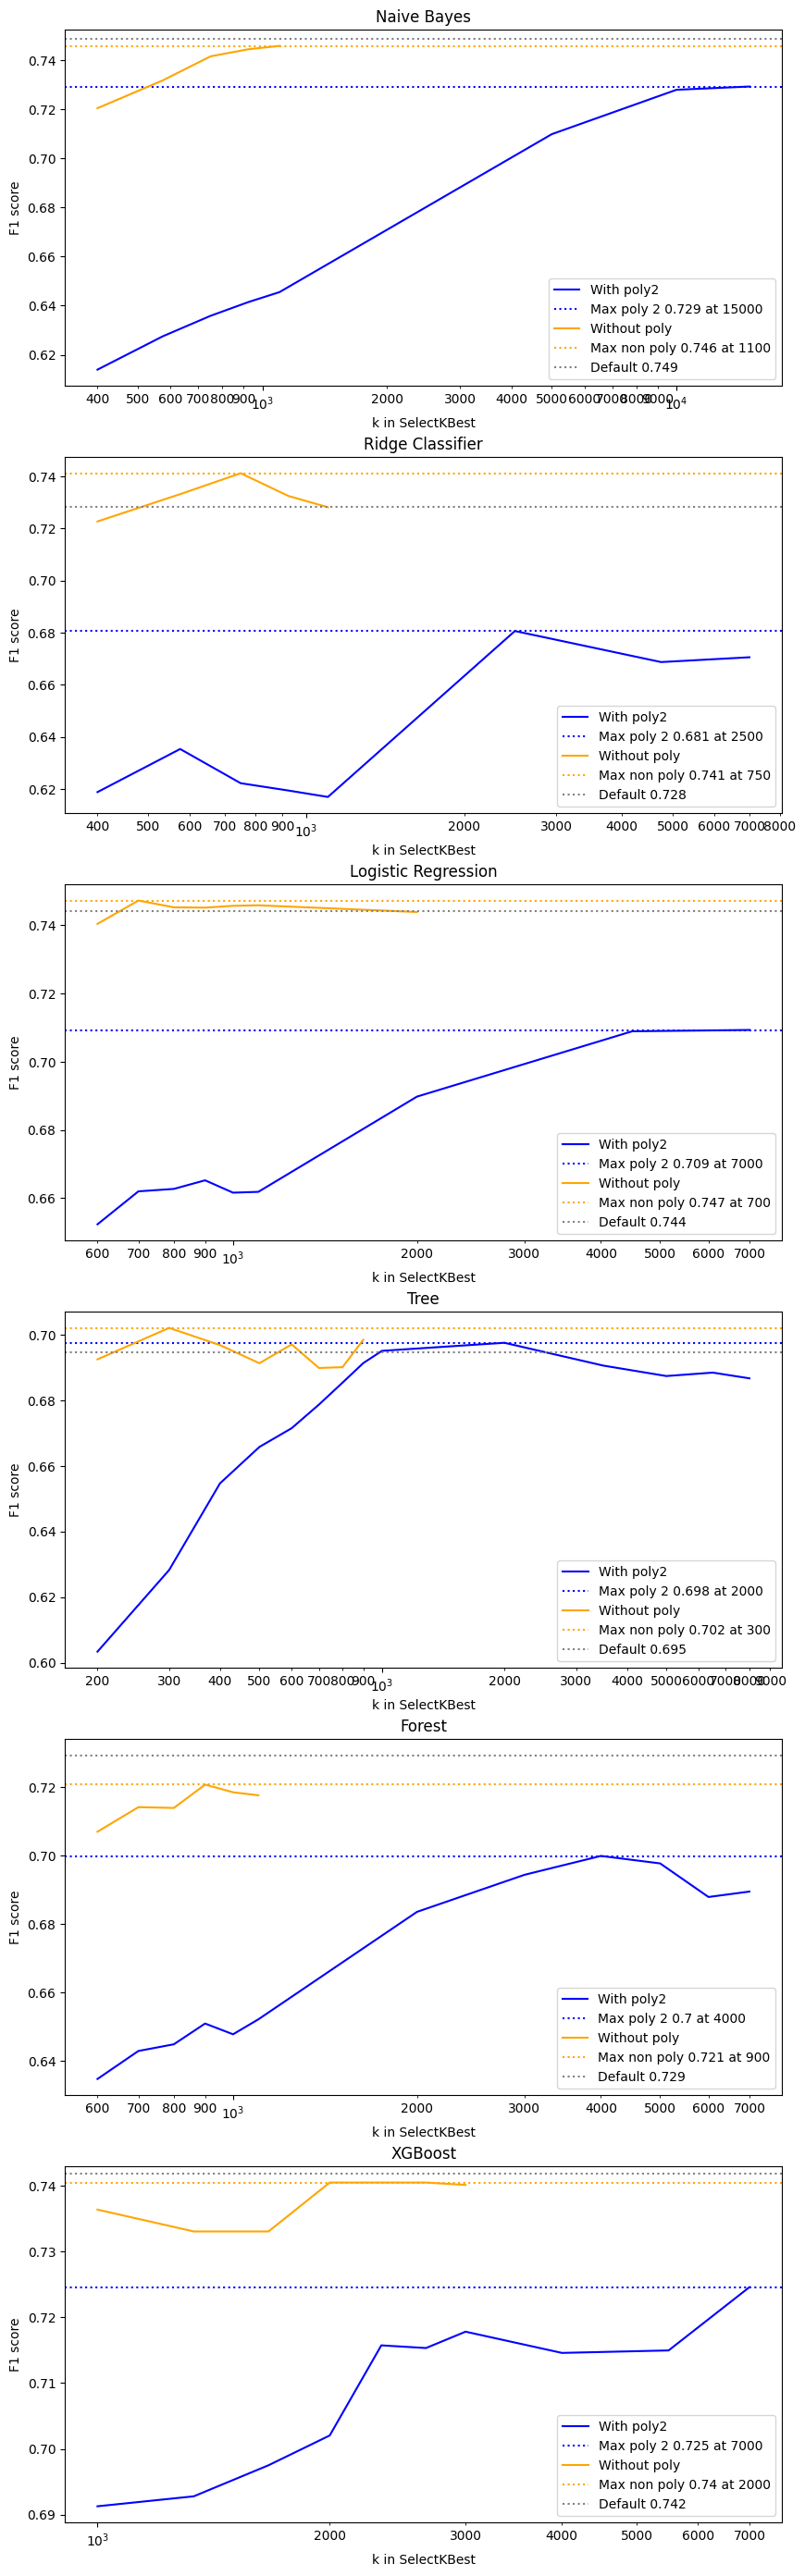

In [80]:
plot_k_range_results(k_range_results)

### TruncatedSVD
* TruncatedSVD is a linear dimensionality reduction technique similar to PCA, but capable of working with sparce matrices 
* I'm going to apply TruncatedSVD on the best results from the previous steps.
* The tuples below reflect the best found values for k for non-poly and poly2 cases
* There's an additional option: Poly2 + BestK 10000. The idea of adding it is to check the hypothesis that SelectBestK when set to too low k might cut some interesting features that might be picked up by TruncatedSVD  

In [120]:
%%time

best_k_dict = {
    Models.rc_key: (750, 2500),
    Models.lr_key: (700, 7000),
    Models.tree_key: (500, 2000),
    Models.forest_key: (1000, 3000),
    Models.xgb_key: (2000, 7000)
}

svd_params_dict = {
    key: {
        'pipe': pipe_with_transformations(key),
        'n_range': np.linspace(100, 1000, 10, dtype=int),
        'no_poly_k': best_k[0],
        'poly_2_k': best_k[1],
        'cv': cv,
        'X': X_full_train,
        'y': y_full_train
    } for key, best_k in best_k_dict.items()
}
    
svd_n_range_results = svd_n_range_scores(svd_params_dict)

CPU times: user 7h 54min 24s, sys: 1h 38min 28s, total: 9h 32min 53s
Wall time: 3h 56min 44s


#### Visualization

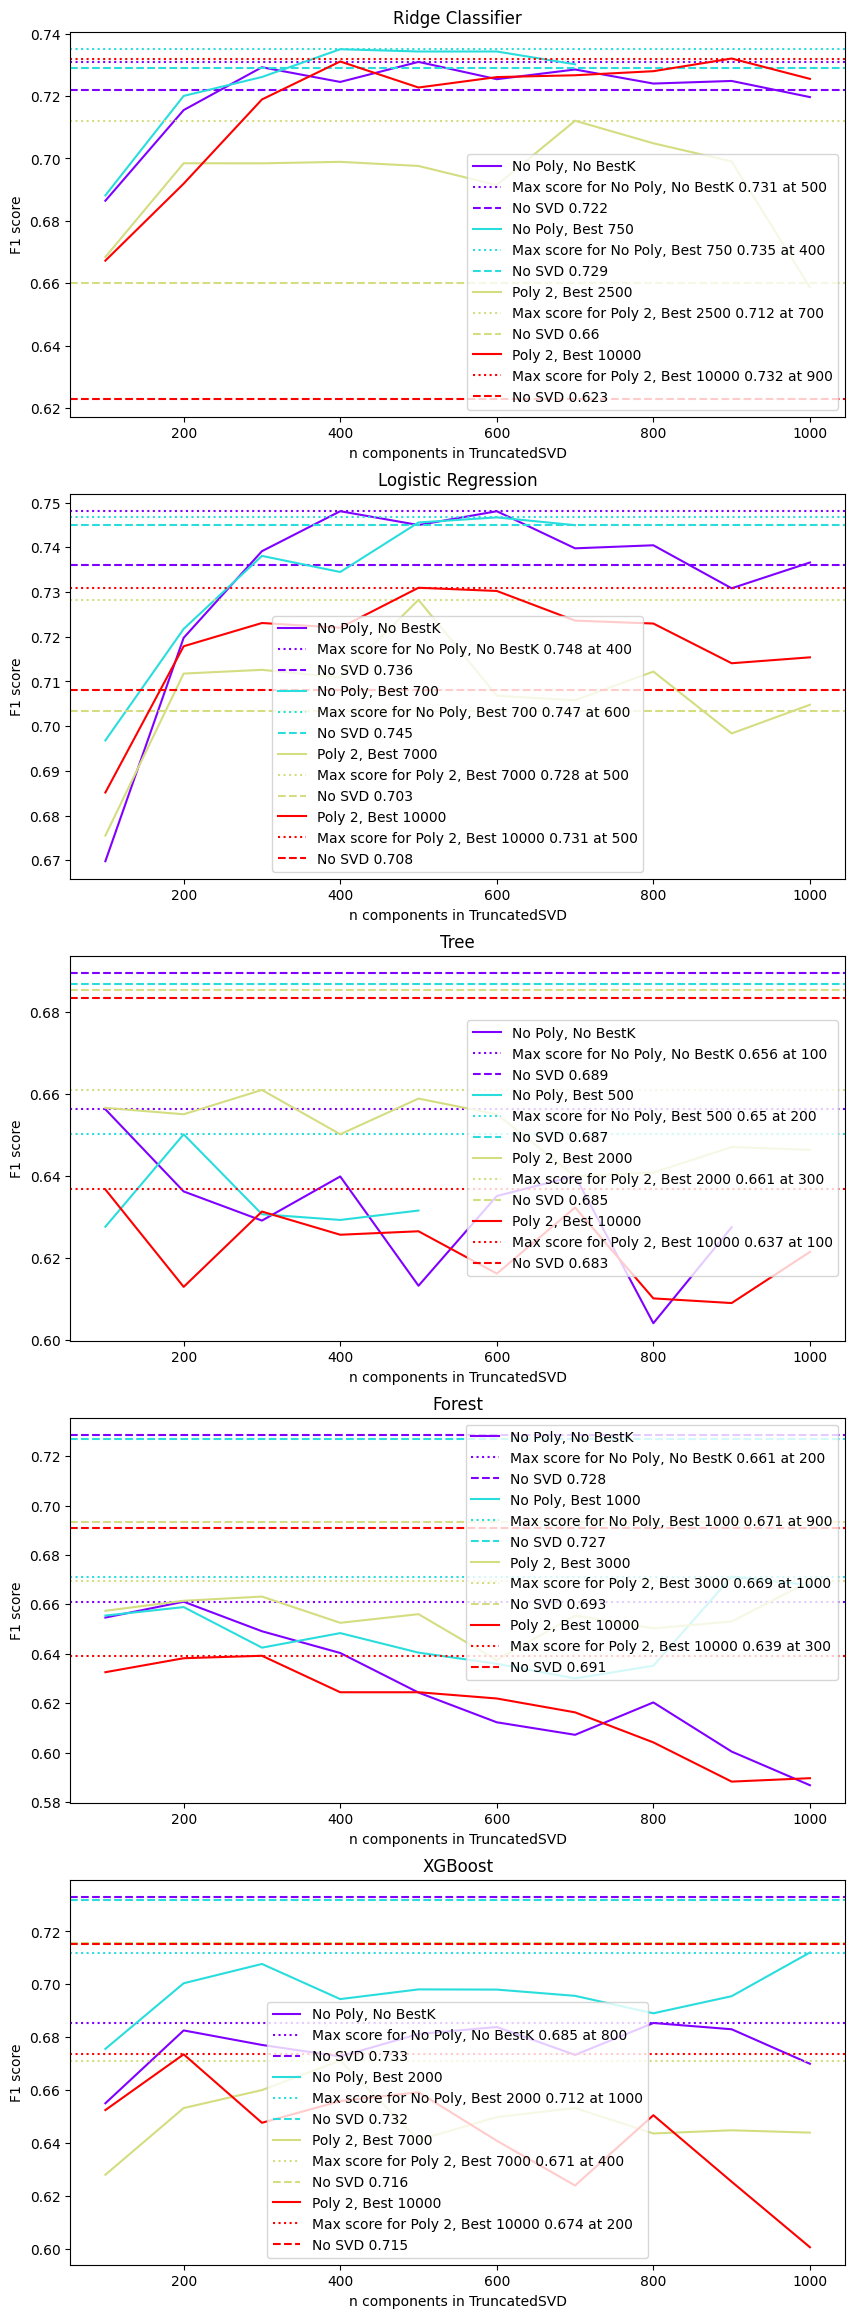

In [82]:
plot_svd__range_results(svd_n_range_results)

### Best transformation parameters and scores

In [83]:
best_transformation_params = {
    Models.nb_key: {'poly2_k_best': 'passthrough', 'svd': 'passthrough'},
    Models.rc_key: {'poly2_k_best__poly2': 'passthrough', 'poly2_k_best__k_best__k': 750, 'svd__n_components': 500},
    Models.lr_key: {'poly2_k_best__poly2': 'passthrough', 'poly2_k_best__k_best__k': 600, 'svd__n_components': 400},
    Models.tree_key: {'poly2_k_best': 'passthrough', 'svd': 'passthrough'},
    Models.forest_key: {'poly2_k_best': 'passthrough', 'svd': 'passthrough'},
    Models.xgb_key: {'poly2_k_best': 'passthrough', 'svd': 'passthrough'}
}

def make_best_transformation_pipeline(key):
    pipeline = pipe_with_transformations(key)

    pipeline.set_params(**(best_transformation_params[key]))
    return pipeline    

In [84]:
best_transformation_pipelines = {
    key: make_best_transformation_pipeline(key) for key in best_transformation_params.keys()
}

In [85]:
%%time
with warnings.catch_warnings():
    warnings.simplefilter('ignore')
    transformation_scores_df = evaluate_pipelines(best_transformation_pipelines, feature_key='Data transformation')

CPU times: user 51.5 s, sys: 39.9 s, total: 1min 31s
Wall time: 23.1 s


In [86]:
pd.concat((default_scores_df, preparation_scores_df, transformation_scores_df))

,Naive Bayes,Ridge Classifier,Logistic Regression,Tree,Forest,XGBoost
Features,,,,,,
Default (x_val),0.733873,0.721860,0.734567,0.662804,0.700984,0.736132
Default (test),0.760383,0.758837,0.762422,0.669298,0.727909,0.742475
Data preparation (x_val),0.748595,0.728327,0.744144,0.694677,0.729309,0.741877
Data preparation (test),0.773688,0.762805,0.767677,0.701700,0.740995,0.759367
Data transformation (x_val),0.748595,0.742506,0.742820,0.694677,0.729309,0.741877
Data transformation (test),0.773688,0.742219,0.748213,0.701700,0.740995,0.759367


### Conclusion
* Data transformation doesn't show any positive effect neither on the Naive Bayes, nor on the Tree-Based models.
* Ther are some improvements on the cross-val score on the Linear classifiers, but the test score drops, which probably means overfitting. 
* Hence I don't take any results of the Data Transformation into the next step of the model hyperparameters tuning. I'll base it on the Data Preparation step instead

In [87]:
def make_best_preparation_pipeline(key):
    pipeline = make_preparation_pipeline(**all_preparation_params[best_preparation_params[key]])
    steps = pipeline.steps
    steps.append (('classifier', make_model(key)))
    return Pipeline(steps)

## Final Models Parameters Tuning
* The general routine will consist of consecutive steps like follows:
    * Keep best results from previous step
    * Optimize next another paramater doing search along a range of values 

### Helpers

In [88]:
def grid_search(pipe, param_grid, X, y):
    """
    grid_search(pipe, param_grid, X, y)

    Performs a grid search on a given pipeline with specified parameters.

    Parameters:
    - pipe (Pipeline): The pipeline to perform the grid search on.
    - param_grid (dict): The parameter grid to search over.
    - X (array-like): The input data.
    - y (array-like): The target data.

    Returns:
    - gs (GridSearchCV): The grid search object.
    """    
    gs = GridSearchCV(pipe, 
                               param_grid = param_grid,
                               scoring='f1',
                               cv=cv) 
    with warnings.catch_warnings():
        warnings.simplefilter("ignore")
        gs.fit(X, y)
    print("Tuned Hyperparameters:", gs.best_params_)
    print(f"F1 score : {gs.best_score_}")
    return gs

In [89]:
from util.plot_util import plot_grid_results

In [90]:
best_fine_tuning_params = {}

### Naive Bayes

#### `alpha`

Tuned Hyperparameters: {'classifier__alpha': 1.0}
F1 score : 0.7485948560615903
CPU times: user 1.78 s, sys: 0 ns, total: 1.78 s
Wall time: 1.78 s


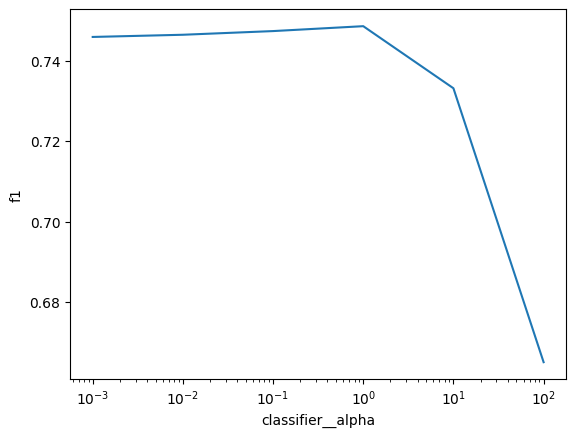

In [91]:
%%time

nb_tuning_grid = {
    'classifier__alpha': np.logspace(-3,2,6)
}

nb_tuning_results = grid_search(make_best_preparation_pipeline(Models.nb_key), nb_tuning_grid, X_full_train, y_full_train)
plot_grid_results(nb_tuning_results, 'classifier__alpha', log=True)

In [92]:
best_fine_tuning_params[Models.nb_key] = {
    'classifier__alpha': 1.0
}

### Ridge Classifier

#### `alpha`, `solver`

Tuned Hyperparameters: {'classifier__alpha': 10.0, 'classifier__solver': 'lsqr'}
F1 score : 0.7421468976172007
CPU times: user 56.9 s, sys: 0 ns, total: 56.9 s
Wall time: 56.9 s


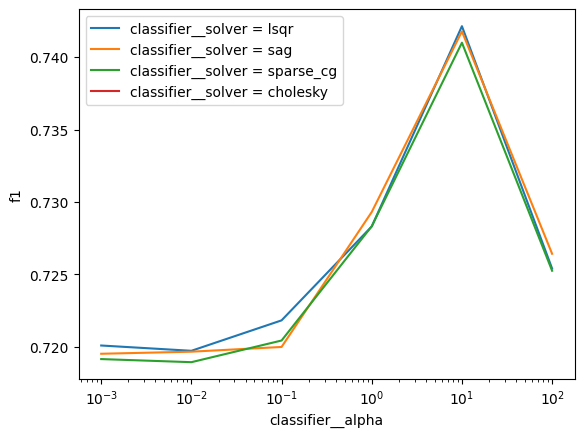

In [93]:
%%time
rc_tuning_grid = {
    'classifier__alpha': np.logspace(-3,2,6),
    'classifier__solver': ['lsqr', 'sag', 'sparse_cg', 'cholesky'],
}

rc_tuning_results = grid_search(make_best_preparation_pipeline(Models.rc_key), rc_tuning_grid, X_full_train, y_full_train)
plot_grid_results(rc_tuning_results, 'classifier__alpha', legend_var='classifier__solver', log=True)

#### `alpha`, `solver` Closer look

Tuned Hyperparameters: {'classifier__alpha': 15, 'classifier__solver': 'sparse_cg'}
F1 score : 0.7456172592381969
CPU times: user 1min 36s, sys: 728 µs, total: 1min 36s
Wall time: 1min 36s


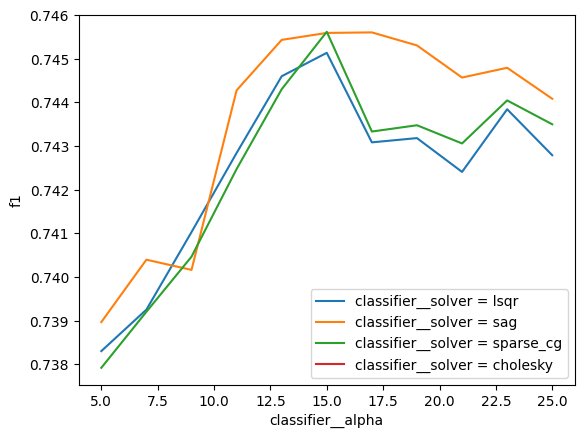

In [94]:
%%time
rc_tuning_grid = {
    'classifier__alpha': range(5, 26, 2),
    'classifier__solver': ['lsqr', 'sag', 'sparse_cg', 'cholesky'],
}

rc_tuning_results = grid_search(make_best_preparation_pipeline(Models.rc_key), rc_tuning_grid, X_full_train, y_full_train)
plot_grid_results(rc_tuning_results, 'classifier__alpha', legend_var='classifier__solver')

* The `sag` solver with alpha=14 obviously shows the best result

In [95]:
best_fine_tuning_params[Models.rc_key] = {
    'classifier__alpha': 14,
    'classifier__solver': 'sag'
}

### Logistic Regression

#### `C`, `solver`

Tuned Hyperparameters: {'classifier__C': 0.1, 'classifier__solver': 'liblinear'}
F1 score : 0.7459217501487693
CPU times: user 49.3 s, sys: 5.01 ms, total: 49.3 s
Wall time: 49.3 s


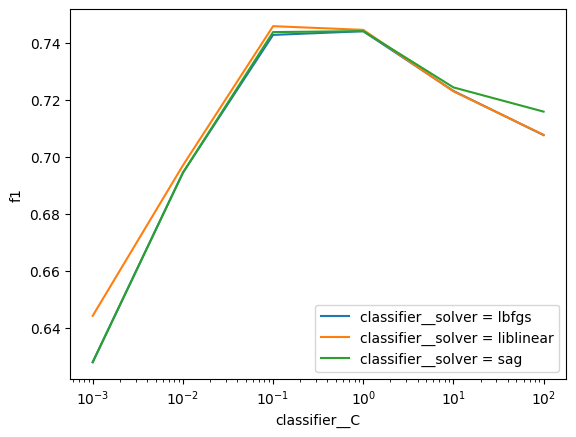

In [96]:
%%time

lr_tuning_grid = {
    'classifier__C': np.logspace(-3,2,6),
    'classifier__solver': ['lbfgs', 'liblinear', 'sag']
}

lr_tuning_results = grid_search(make_best_preparation_pipeline(Models.lr_key), lr_tuning_grid, X_full_train, y_full_train)
plot_grid_results(lr_tuning_results, 'classifier__C', legend_var='classifier__solver', log=True)

Tuned Hyperparameters: {'classifier__C': 0.25000000000000006, 'classifier__solver': 'lbfgs'}
F1 score : 0.751786752686634
CPU times: user 54.4 s, sys: 4.59 ms, total: 54.4 s
Wall time: 54.4 s


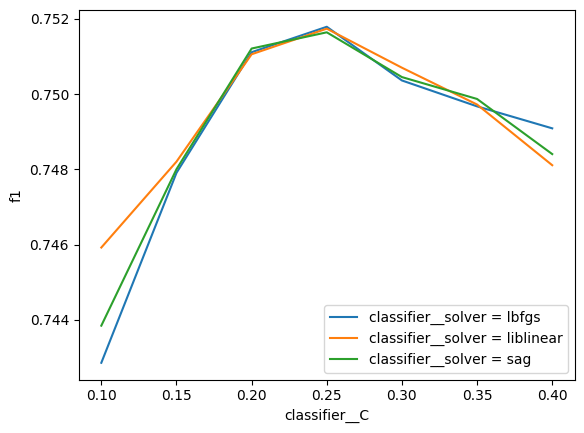

In [97]:
%%time

lr_tuning_grid = {
    'classifier__C': np.arange(0.1, 0.41, 0.05),
    'classifier__solver': ['lbfgs', 'liblinear', 'sag']
}

lr_tuning_results = grid_search(make_best_preparation_pipeline(Models.lr_key), lr_tuning_grid, X_full_train, y_full_train)
plot_grid_results(lr_tuning_results, 'classifier__C', legend_var='classifier__solver')

* Solver seems to make no difference, so the default `lbgfs` is ok, so only the `C` (regularization strength) parameter goes to the params dict

In [98]:
best_fine_tuning_params[Models.lr_key] = {
    'classifier__C': 0.25
}

### Decision Tree

#### `criterion`, `max_depth`

In [99]:
%%time

tree_tuning_grid = {
    'classifier__criterion': ['gini', 'entropy'],
    'classifier__max_depth': [2, 3, 5, 10, 20, 50, 100, 120, 130, 140, 150, 170, 200, 300, None]
}

tree_tuning_results = grid_search(make_best_preparation_pipeline(Models.tree_key), tree_tuning_grid, X_full_train, y_full_train)

Tuned Hyperparameters: {'classifier__criterion': 'gini', 'classifier__max_depth': 170}
F1 score : 0.7094319786677988
CPU times: user 12.1 s, sys: 0 ns, total: 12.1 s
Wall time: 12.1 s


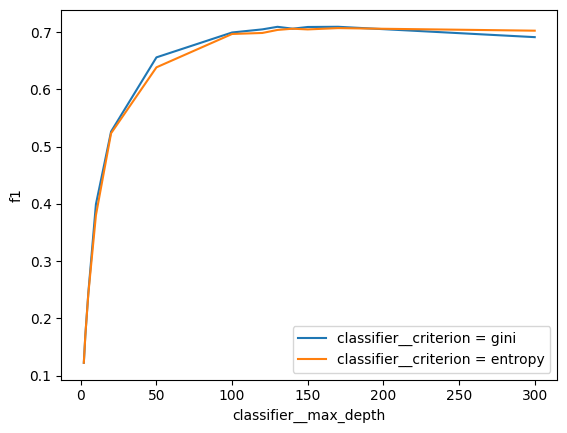

In [100]:
plot_grid_results(tree_tuning_results, 'classifier__max_depth', legend_var='classifier__criterion')

#### `max_depth`, `min_samples_leaf`

Tuned Hyperparameters: {'classifier__criterion': 'gini', 'classifier__max_depth': 140, 'classifier__min_samples_leaf': 4}
F1 score : 0.7205526329658274
CPU times: user 30.4 s, sys: 0 ns, total: 30.4 s
Wall time: 30.4 s


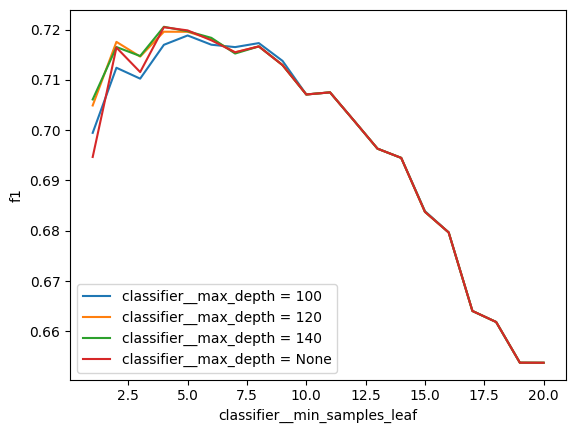

In [101]:
%%time

tree_tuning_grid = {
    'classifier__criterion': ['gini'],
    'classifier__max_depth': [100, 120, 140, None],
    'classifier__min_samples_leaf': np.linspace(1, 20, 20, dtype=int)
}

tree_tuning_results = grid_search(make_best_preparation_pipeline(Models.tree_key), tree_tuning_grid, X_full_train, y_full_train)
plot_grid_results(tree_tuning_results, 'classifier__min_samples_leaf', legend_var='classifier__max_depth')

#### `max_depth`, `min_samples_split`

Tuned Hyperparameters: {'classifier__criterion': 'gini', 'classifier__max_depth': None, 'classifier__min_samples_split': 135}
F1 score : 0.7265596736513301
CPU times: user 45.6 s, sys: 16.8 ms, total: 45.6 s
Wall time: 45.6 s


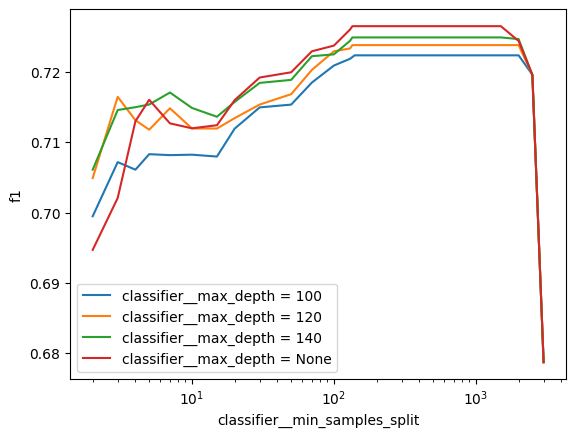

In [102]:
%%time

tree_tuning_grid = {
    'classifier__criterion': ['gini'],
    'classifier__max_depth': [100, 120, 140, None],
    'classifier__min_samples_split': [2, 3, 4, 5, 7, 10, 15, 20, 30, 50, 70, 100, 130, 135, 140, 150, 160, 170, 200, 300, 400, 500, 600, 800, 1000, 1500, 2000, 2500, 3000]
}

tree_tuning_results = grid_search(make_best_preparation_pipeline(Models.tree_key), tree_tuning_grid, X_full_train, y_full_train)
plot_grid_results(tree_tuning_results, 'classifier__min_samples_split', legend_var='classifier__max_depth', log=True)

In [103]:
best_fine_tuning_params[Models.tree_key] = {
    'classifier__criterion': 'gini',
    'classifier__max_depth': None,
    'classifier__min_samples_split': 135
}

### Random Forest

#### `max_depth`

Tuned Hyperparameters: {'classifier__max_depth': None, 'classifier__n_estimators': 100}
F1 score : 0.7293087909084646
CPU times: user 1min 54s, sys: 20.9 s, total: 2min 14s
Wall time: 3min 56s


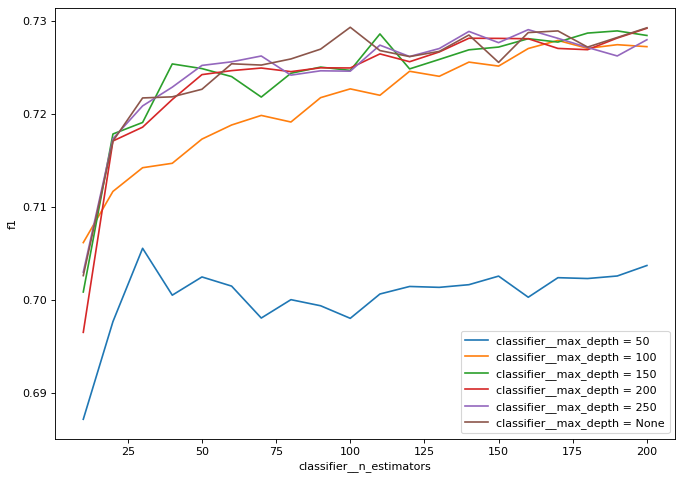

In [104]:
%%time

forest_tuning_grid =  {
    'classifier__max_depth': [50, 100, 150, 200, 250, None],
    'classifier__n_estimators': np.linspace(10, 200, 20, dtype=int)
}

forest_tuning_results = grid_search(make_best_preparation_pipeline(Models.forest_key), forest_tuning_grid, X_full_train, y_full_train)
figure(figsize=(10, 7), dpi=80)
plot_grid_results(forest_tuning_results, 'classifier__n_estimators', legend_var='classifier__max_depth')

#### `max_features`

Tuned Hyperparameters: {'classifier__max_depth': None, 'classifier__max_features': 'log2', 'classifier__n_estimators': 180}
F1 score : 0.7314702875419117
CPU times: user 1min 21s, sys: 16.3 s, total: 1min 37s
Wall time: 3min 22s


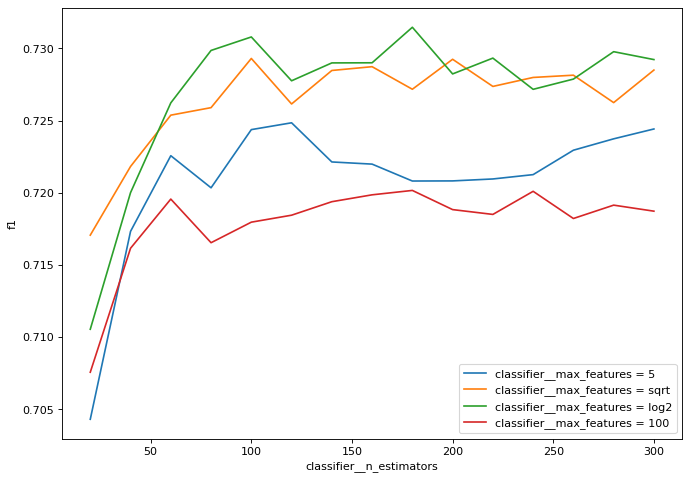

In [105]:
%%time

forest_tuning_grid =  {
    'classifier__max_depth': [None],
    'classifier__max_features': [5, 'sqrt', 'log2', 100],
    'classifier__n_estimators': np.linspace(20, 300, 15, dtype=int)
}


forest_tuning_results = grid_search(make_best_preparation_pipeline(Models.forest_key), forest_tuning_grid, X_full_train, y_full_train)
figure(figsize=(10, 7), dpi=80)
plot_grid_results(forest_tuning_results, 'classifier__n_estimators', legend_var='classifier__max_features')

#### `min_samples_leaf`

Tuned Hyperparameters: {'classifier__max_depth': None, 'classifier__max_features': 'log2', 'classifier__min_samples_leaf': 2, 'classifier__n_estimators': 320}
F1 score : 0.7500232709324489
CPU times: user 2min 10s, sys: 33.2 s, total: 2min 43s
Wall time: 3min 16s


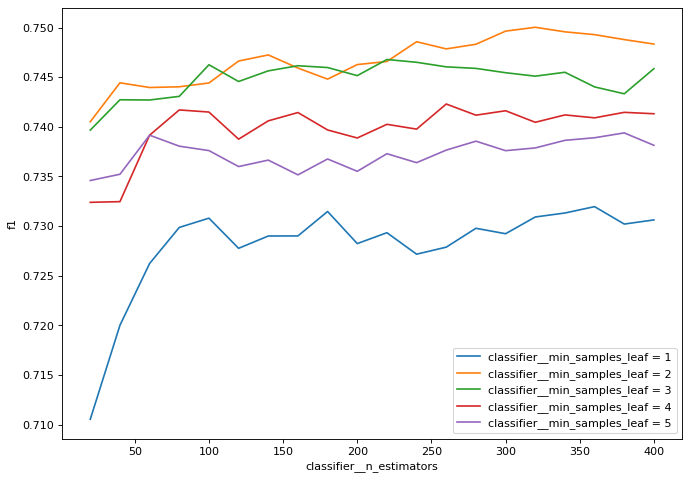

In [106]:
%%time

forest_tuning_grid =  {
    'classifier__max_depth': [None],
    'classifier__max_features': ['log2'],
    'classifier__min_samples_leaf': [1, 2, 3, 4, 5],
    'classifier__n_estimators': np.linspace(20, 400, 20, dtype=int)
}


forest_tuning_results = grid_search(make_best_preparation_pipeline(Models.forest_key), forest_tuning_grid, X_full_train, y_full_train)
figure(figsize=(10, 7), dpi=80)
plot_grid_results(forest_tuning_results, 'classifier__n_estimators', legend_var='classifier__min_samples_leaf')

#### `min_samples_leaf`, `min_samples_split`

Tuned Hyperparameters: {'classifier__max_depth': None, 'classifier__max_features': 'log2', 'classifier__min_samples_leaf': 1, 'classifier__min_samples_split': 100, 'classifier__n_estimators': 250}
F1 score : 0.7521314253803426
CPU times: user 59.7 s, sys: 15.4 s, total: 1min 15s
Wall time: 1min 15s


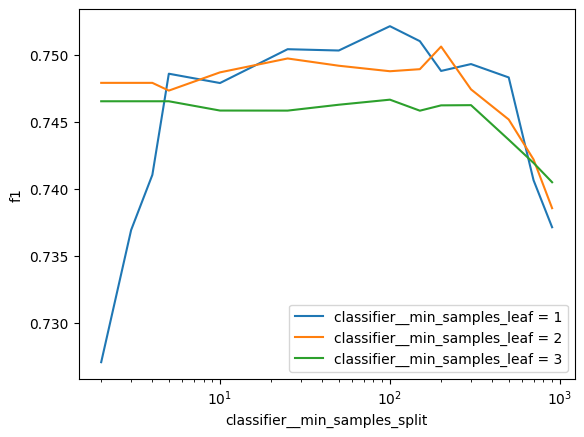

In [107]:
%%time

forest_tuning_grid =  {
    'classifier__max_depth': [None],
    'classifier__max_features': ['log2'],
    'classifier__min_samples_leaf': [1, 2, 3],

    'classifier__min_samples_split': [2, 3, 4, 5, 10, 25, 50, 100, 150, 200, 300, 500, 700, 900],
    'classifier__n_estimators': [250]
}


forest_tuning_results = grid_search(make_best_preparation_pipeline(Models.forest_key), forest_tuning_grid, X_full_train, y_full_train)
plot_grid_results(forest_tuning_results, 'classifier__min_samples_split', legend_var='classifier__min_samples_leaf', log=True)

Tuned Hyperparameters: {'classifier__max_depth': None, 'classifier__max_features': 'log2', 'classifier__min_samples_leaf': 2, 'classifier__min_samples_split': 200, 'classifier__n_estimators': 260}
F1 score : 0.7512387353680756
CPU times: user 47.5 s, sys: 12.5 s, total: 60 s
Wall time: 55.8 s


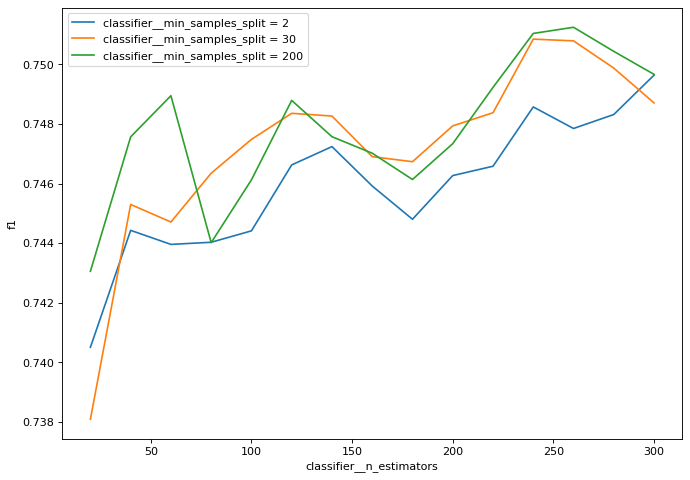

In [108]:
%%time

forest_tuning_grid =  {
    'classifier__max_depth': [None],
    'classifier__max_features': ['log2'],
    'classifier__min_samples_leaf': [2],
    'classifier__min_samples_split': [2, 30, 200],
    'classifier__n_estimators': np.linspace(20, 300, 15, dtype=int)
}


forest_tuning_results = grid_search(make_best_preparation_pipeline(Models.forest_key), forest_tuning_grid, X_full_train, y_full_train)
figure(figsize=(10, 7), dpi=80)
plot_grid_results(forest_tuning_results, 'classifier__n_estimators', legend_var='classifier__min_samples_split')

Tuned Hyperparameters: {'classifier__max_depth': None, 'classifier__max_features': 'log2', 'classifier__min_samples_leaf': 1, 'classifier__min_samples_split': 100, 'classifier__n_estimators': 200}
F1 score : 0.7531567052253132
CPU times: user 34.1 s, sys: 8.75 s, total: 42.9 s
Wall time: 39.1 s


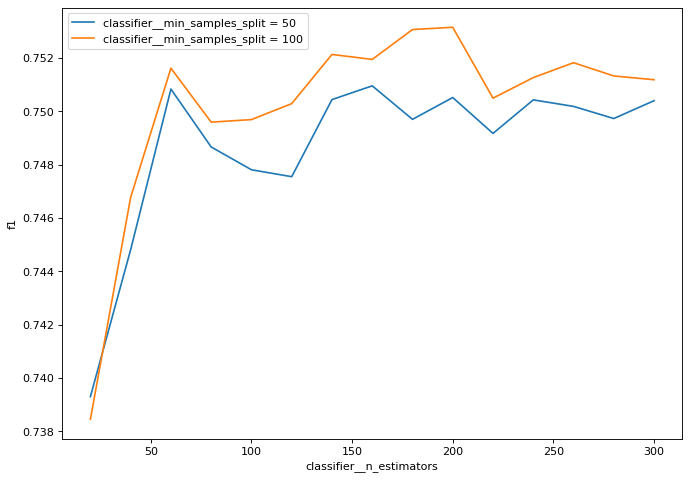

In [109]:
%%time

forest_tuning_grid =  {
    'classifier__max_depth': [None],
    'classifier__max_features': ['log2'],
    'classifier__min_samples_leaf': [1],
    'classifier__min_samples_split': [50, 100],
    'classifier__n_estimators': np.linspace(20, 300, 15, dtype=int)
}


forest_tuning_results = grid_search(make_best_preparation_pipeline(Models.forest_key), forest_tuning_grid, X_full_train, y_full_train)
figure(figsize=(10, 7), dpi=80)
plot_grid_results(forest_tuning_results, 'classifier__n_estimators', legend_var='classifier__min_samples_split')

In [110]:
best_fine_tuning_params[Models.forest_key] =  {
    'classifier__max_depth': None,
    'classifier__max_features': 'log2',
    'classifier__min_samples_leaf': 1,
    'classifier__min_samples_split': 100,
    'classifier__n_estimators': 200
}

### XGBoost

#### `learning_rate`

Tuned Hyperparameters: {'classifier__learning_rate': 0.3, 'classifier__n_estimators': 150}
F1 score : 0.7469810572257779
CPU times: user 8min 6s, sys: 1.23 s, total: 8min 7s
Wall time: 2min 46s


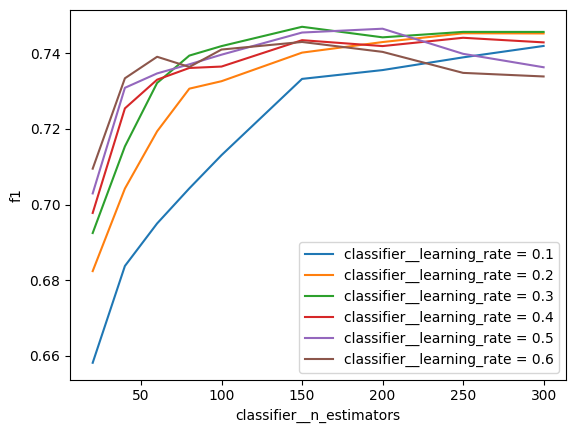

In [111]:
%%time

xgb_tuning_grid = {
    'classifier__n_estimators': np.concatenate((np.linspace(20, 100, 5, dtype=int), 
                                           np.linspace(150, 300, 4, dtype=int))),    
    'classifier__learning_rate': [0.1, 0.2, 0.3, 0.4, 0.5, 0.6],
}

xgb_tuning_results = grid_search(make_best_preparation_pipeline(Models.xgb_key), xgb_tuning_grid, X_full_train, y_full_train)
plot_grid_results(xgb_tuning_results, 'classifier__n_estimators', legend_var='classifier__learning_rate')

#### `max_depth`

Tuned Hyperparameters: {'classifier__learning_rate': 0.3, 'classifier__max_depth': 6, 'classifier__n_estimators': 150}
F1 score : 0.7469810572257779
CPU times: user 7min 6s, sys: 1.11 s, total: 7min 7s
Wall time: 2min 38s


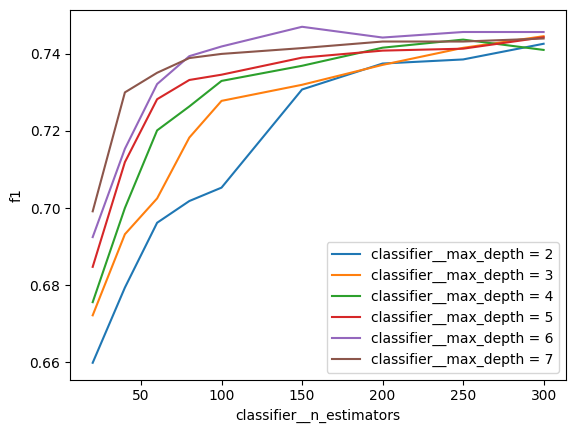

In [112]:
%%time

xgb_tuning_grid = {
    'classifier__n_estimators': np.concatenate((np.linspace(20, 100, 5, dtype=int), 
                                           np.linspace(150, 300, 4, dtype=int))),    
    'classifier__learning_rate': [0.3],
    'classifier__max_depth': [2, 3, 4, 5, 6, 7]
}

xgb_tuning_results = grid_search(make_best_preparation_pipeline(Models.xgb_key), xgb_tuning_grid, X_full_train, y_full_train)
plot_grid_results(xgb_tuning_results, 'classifier__n_estimators', legend_var='classifier__max_depth')

#### `min_child_weight`

Tuned Hyperparameters: {'classifier__learning_rate': 0.3, 'classifier__max_depth': 6, 'classifier__min_child_weight': 1, 'classifier__n_estimators': 150}
F1 score : 0.7469810572257779
CPU times: user 5min 21s, sys: 939 ms, total: 5min 22s
Wall time: 1min 49s


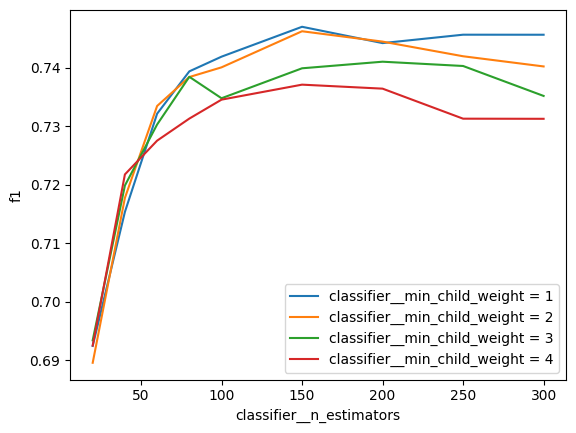

In [113]:
%%time

xgb_tuning_grid = {
    'classifier__n_estimators': np.concatenate((np.linspace(20, 100, 5, dtype=int), 
                                           np.linspace(150, 300, 4, dtype=int))),    
    'classifier__learning_rate': [0.3],
    'classifier__max_depth': [6],
    'classifier__min_child_weight': [1, 2, 3, 4]
}

xgb_tuning_results = grid_search(make_best_preparation_pipeline(Models.xgb_key), xgb_tuning_grid, X_full_train, y_full_train)
plot_grid_results(xgb_tuning_results, 'classifier__n_estimators', legend_var='classifier__min_child_weight')

In [114]:
best_fine_tuning_params[Models.xgb_key] = {
    'classifier__n_estimators': 150,    
    'classifier__learning_rate': 0.3,
    'classifier__max_depth': 6,
    'classifier__min_child_weight': 1
}

### Best fine tuning score

In [115]:
def make_best_fine_tuned_pipeline(key):
    pipeline = make_best_preparation_pipeline(key)

    pipeline.set_params(**(best_fine_tuning_params[key]))
    return pipeline    

In [116]:
best_fine_tuning_pipelines = {
    key: make_best_fine_tuned_pipeline(key) for key in best_fine_tuning_params.keys()
}

In [117]:
%%time
with warnings.catch_warnings():
    warnings.simplefilter('ignore')
    fine_tuning_scores_df = evaluate_pipelines(best_fine_tuning_pipelines, feature_key='Fine tuning')

CPU times: user 21.2 s, sys: 876 ms, total: 22.1 s
Wall time: 14.1 s


In [118]:
pd.concat((default_scores_df, preparation_scores_df, fine_tuning_scores_df))

,Naive Bayes,Ridge Classifier,Logistic Regression,Tree,Forest,XGBoost
Features,,,,,,
Default (x_val),0.733873,0.721860,0.734567,0.662804,0.700984,0.736132
Default (test),0.760383,0.758837,0.762422,0.669298,0.727909,0.742475
Data preparation (x_val),0.748595,0.728327,0.744144,0.694677,0.729309,0.741877
Data preparation (test),0.773688,0.762805,0.767677,0.701700,0.740995,0.759367
Fine tuning (x_val),0.748595,0.746462,0.751787,0.726560,0.753157,0.746981
Fine tuning (test),0.773688,0.757962,0.773481,0.733781,0.772727,0.767213


# Observations and conclusions

In [119]:
best_preparation_params

Naive Bayes                                             Keyword
Ridge Classifier                 Stopwords + Stemming + Keyword
Logistic Regression    Keyword + Location + Hashtags + Stemming
Tree                                    Stopwords + URL Cleaner
Forest                                    Keyword + URL Cleaner
XGBoost                Keyword + Location + Hashtags + Stemming
dtype: object

## All Models
* It's worth noting that the test scores are everywhere significantly better than the cross-val score. It probably can be explained by the fact that test score is measured with a model trained on the whole full train set, while for cross-val only the part of it is used, which is 75% in this case
    * It may indicate that the results will be improved with growth of the training data set

### Naive Bayes
* Data preparation: `
    * `keyword` column
* Data transformation:
    * SelectKBest had no improvement on the score. Almost achieved the default score when `k` approached to the number of generated features. Which was obviously expected
    * The SVD was not applicable, since Naive Bayes works with integer frequencies
* Model parameter tuning: 
    * resulted in default parameters
* Overall performance:
    * While utilizing the least of data preparation and transformation steps among classifiers, it showed the best results across all the stages right after the Preparation Stage
    

### Linear Classifiers (Ridge Classifier and Logistic Regression)
* Data preparation:
    * RC: `Stopwords + Stemming + Keyword`
    * LR: `Keyword + Location + Hashtags + Stemming`
    * For both models the preparation shows some growth around ~1% score, demonstrated by both x-val and test values, so probably it's somewhat trustworthy
* Data transformation:
    * RC: No Polynomialization, SelectKBest with k=750, TruncatedSVD with 600 components
    * LR: Keyword + Location + Hashtags + Stemming
    * Both models showed some growth on cross-val score, but at the same time the test score dropped quite significantly. 
        * The reason is probably overfitting
* Model parameter tuning:
    * RC: after regularization strength tuning showed some growth on cross-val score. At the same time there was a slight (~0.5%) drop in the test score which might indicate slight overfitting, but I thing it's rather a fluctuation
    * LR: proven growth

### Tree-based Classifiers (Decision Tree, Random Forest and XGBoost)
* Data preparation:
    * Tree: `Stopwords + URL Cleaner`
    * Forest: `Keyword + URL Cleaner`
    * XGBoost: `Keyword + Location + Hashtags + Stemming`
    
* Data transformation:
    * On all the Tree-based classifiers:
        * SelectKBest: no improve
        * PolynomialFeatures: significant drop
        * TruncatedSVD: significant drop
    * Interpretation:
        * Both PolynomialFeatures and TruncatedSVD are meant either to improve data representation (remove noise or add hidden patterns in linear space. Since Tree-Based models do not operate in linear space, this is of no use for them
        * SelectKBest seems to be able to bring some value, but probably we need a bigger dataset with more features after vectorization
* Model parameter tuning:
    * All Tree-based Classifiers showed very nice growth on both cross-val and test values
    * DecisionTreeClassifier showed interesting behaviour on `min_samples_leaf` and `min_samples_split` parameters. The optimal value for `min_samples_leaf` was 4, and the mean score was dropping quite significantly when I increased it. THe optimal value for `min_samples_split` was 135 and the score curve was flat after this value until ~1500

##  General Conclusion
* The Naive Bayes seems to work the best among the models on data like tweets
* The fact that all models, despite being tuned in different ways, converge to a similar mean score (~76-77%) in the end, might indicate that this value is close to the limit of the sentiment information this data contains
    * This possibly can be improved by bringing more information for example with pretrained embeddings

## Next steps 

* Try other techniques
    * Pretrained embeddings. It can happen that finding synonyms within data and encoding them as the same token will improve the predicting power of our models
    * Train a neural network, preferably CNN
* Try more preparation steps, such as:
    * complete deduplication at the preparation stage
    * trying different min_df for the vectorizers
    * regrouping transformers inside the pipelines 